# Forecast skill analysis

This notebook presents different methods to evaluate and visualize the skill of a forecasting model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns

import modelskill as ms

sns.set_palette("Set1")

In [2]:
def path_to_file(filename):
    return f"../tests/testdata/forecast_skill/{filename}"

matched_model_results = pd.read_csv(path_to_file("matched_model_results.csv"), parse_dates=True, index_col=0)
matched_model_results.round(2).head(7)

,lead_time,model_1,model_2,observation
date,,,,
2023-01-07,1,13804.10,12663.04,14319.96
2023-01-07,2,13302.96,12898.16,14319.96
2023-01-07,3,13388.44,13505.24,14319.96
2023-01-07,4,13014.56,13444.72,14319.96
2023-01-07,5,12845.50,13086.09,14319.96
2023-01-07,6,12801.62,13413.75,14319.96
2023-01-07,7,13003.76,13204.51,14319.96


We depart from a dataframe containing matched results from two models; each model allows us to forecast the value of an arbitrary variable _X_ up to 7 days in advance. The `lead_time` column in the previous dataframe represents how many days in advance did we forecast the value of _X_. To see how to generate such dataframe, consider visiting the [data wrangling notebook](../notebooks/Forecast_data_wrangling.ipynb).

Our goal is to assess which of the two model candidates (`model_1` and `model_2`) better represent an underlying observed system. When comparing models, we often want to have a simple benchmark model to guarantee that our candidate models improve other naive prediction methods based on simple heuristics. For instance, a model that is commonly used as benchmark is a model that returns the mean of our available observations. `modelskill` provides tools to generate such a naive model by using the `DummyModelResult` class, as can be seen below.

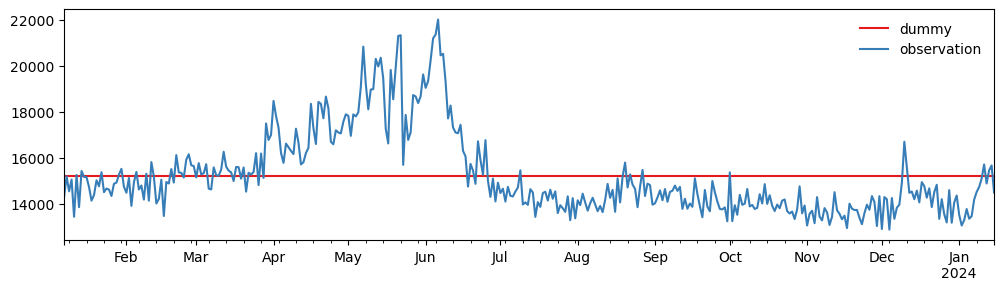

In [3]:
observations = matched_model_results["observation"].drop_duplicates().to_frame()

obs = ms.PointObservation(observations)
mr = ms.DummyModelResult(strategy='mean')
pmr = mr.extract(obs).to_dataframe()

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
pmr.merge(observations, on="time").plot(ax=ax)
ax.set_xlabel("")
ax.legend(frameon=False)
plt.show()


Now, we proceed to merge the results of this dummy model with our matched results.

In [4]:
pmr.index.name = "date"
matched_model_results = matched_model_results.join(pmr, on="date", how="inner")

Finally, we include the results of the model at lead time equal to zero to improve the visualization of the change of skill with the horizon increase. Notice that, for all models except the dummy, we are copying the values of the observations since we are assuming that, at the time of the forecast we have already observed the value of _X_. The dummy model is excluded from this operation since that candidate is only used as benchmark.

In [5]:
observations_ = observations["observation"]
dummy_ = matched_model_results[["dummy"]].reset_index().drop_duplicates().set_index("date").sort_index()["dummy"]

lead_time_zero = pd.DataFrame(
    {
        "lead_time": 0,
        "model_1": observations_,
        "model_2": observations_,
        "observation": observations_,
        "dummy": dummy_,
    },
    index=observations.index
)
lead_time_zero.index.name = "date"
matched_model_results = pd.concat([matched_model_results, lead_time_zero]).sort_values(["date", "lead_time"])

matched_model_results.round(2).head(8)

,lead_time,model_1,model_2,observation,dummy
date,,,,,
2023-01-07,0,14319.96,14319.96,14319.96,15237.57
2023-01-07,1,13804.10,12663.04,14319.96,15237.57
2023-01-07,2,13302.96,12898.16,14319.96,15237.57
2023-01-07,3,13388.44,13505.24,14319.96,15237.57
2023-01-07,4,13014.56,13444.72,14319.96,15237.57
2023-01-07,5,12845.50,13086.09,14319.96,15237.57
2023-01-07,6,12801.62,13413.75,14319.96,15237.57
2023-01-07,7,13003.76,13204.51,14319.96,15237.57


With the previous dataframe, it is straightforward to generate the following skill table. Recall that we want to analyze how the models performs for different horizons (from 1 to 7 days ahead), for this reason we pass the column with the lead time as `aux_items`. Then, we can filter the results by model and by lead time.

In [6]:
cmp = ms.from_matched(matched_model_results, mod_items=["model_1", "model_2", "dummy"], aux_items=["lead_time"], obs_item="observation")

metrics = ["bias", "rmse", "mae", "mape"]
sk = cmp.skill(by=["model", "lead_time"], metrics=metrics).sort_index()
sk.round(2).style()

## Plotting skill

Now we can directly use the plotting functionality from `modelskill`, with minimal extra formatting, to visualize the skill table as follows. 

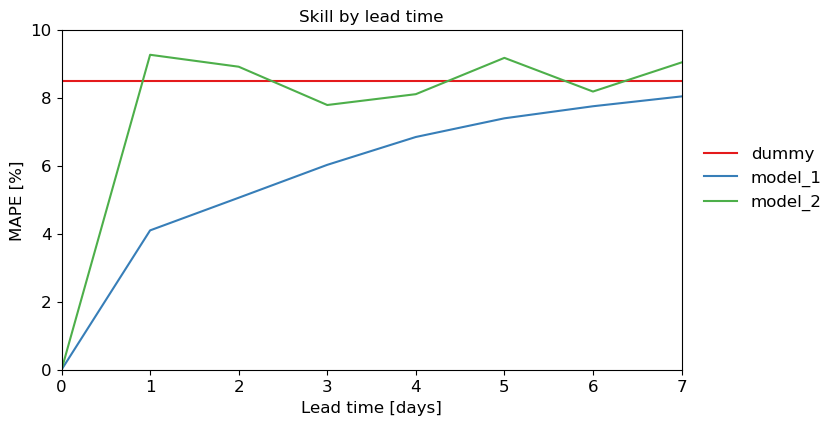

In [8]:
def _format_ax(ax, xlims, ylims):
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_xlabel("Lead time [days]", fontsize=12)
    ax.set_ylabel("MAPE [%]", fontsize=12)
    ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.25, 0.7)),
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.set_title("Skill by lead time")
    ax.figure.autofmt_xdate(rotation=0, ha='center')
    
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sk.mape.plot.line(ax=ax)
_format_ax(ax, xlims=(0, 7), ylims=(0, 10))
plt.show()

Notice that, in this case, we have chosen the MAPE as the skill measure. 

The previous figure suggests that model 2 is not better than the naive approach, on the other, hand model 1 is a clear improvement. Still, the skill of Model 1 decreases with lead time and, as we get close to the 7 days horizon, the three models have very similar performance. It is worth mentioning that the trend in model 1 is often observed when analyzing forecasting models, as the most recent observations contain more information about future values of _X_.

### Skill as a distribution

The results in the previous section are generated by computing the skill aggregating errors per lead time. However, we might instead be interested in how the skill is distributed rather than evaluating it as a single value. In order to do this, we define the following function, which extends the matched results with three new columns: `error`, `absolute_error` and `percentage_error`.

In [9]:
def generate_melted_error_df(matched_results):
    melted_model_results = pd.melt(matched_results.reset_index(), id_vars=["time", "lead_time", "observation"], var_name="model")

    melted_model_results["error"] = melted_model_results["observation"] - melted_model_results["value"]
    melted_model_results["absolute_error"] = abs(melted_model_results["error"])
    melted_model_results["percentage_error"] = 100 * melted_model_results["absolute_error"] / melted_model_results["observation"]

    return melted_model_results

Next, we define a function that, given the extended matched results, plots the distribution of errors by model and lead time.

In [28]:
def plot_error_distribution_array(mmr, diag_ylims=(0, 20)):

    def plot_skill_quantile_by_leadtime(df, ax):
        for interval in [25, 50, 75]:
            sns.lineplot(
                df,
                x="lead_time",
                y="percentage_error",
                estimator="median",
                errorbar=("pi", interval),
                hue="model",
                ax=ax,
                linewidth=2.5,
                err_kws=dict(linewidth=0, alpha=0.15)
            )
        
        ax.legend([], [], frameon=False)
        ax.set_xlabel("Lead time [days]", fontsize=12)
        ax.set_ylabel(ylabel_dict[errorcol], fontsize=12)

    def plot_model_comparison_with_violinplot(df, ax):
        sns.violinplot(
            data=df,
            x="lead_time",
            y=errorcol,
            hue="model",
            split=True,
            gap=0.15,
            inner="quarts",
            ax=ax,
            alpha=0.9,
            saturation=0.7,
            bw_adjust=0.6,
            common_norm=True,
            density_norm="area",
            cut=0,
        )
        ax.spines[['right', 'top']].set_visible(False)
        ax.legend(frameon=False, ncols = 2)
        ax.set_xlabel("")
        ax.set_ylabel("")

    def create_empty_plot_with_legend(ax):

        rectangle_color = sns.color_palette().as_hex()[0]
        rect1 = Patch(facecolor=rectangle_color, alpha=0.45, label='25%')
        rect2 = Patch(facecolor=rectangle_color, alpha=0.30, label='50%')
        rect3 = Patch(facecolor=rectangle_color, alpha=0.15, label='75%')
        line = Line2D([0], [0], color=rectangle_color, label='Median')
        ax.legend(handles=[rect1, rect2, rect3, line], loc='upper right', title='Error quantiles:', frameon=False)
        ax.set_axis_off()

    ylabel_dict = {"error": "Error", "absolute_error": "Absolute error", "percentage_error": "Percentage error [%]"}
    errorcol = "percentage_error"

    models = mmr["model"].unique().tolist()

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))

    for i, model_i in enumerate(models):

        df_ii = mmr.loc[mmr["model"] == model_i, :].copy()

        plot_skill_quantile_by_leadtime(df_ii, axes[i, i])
        axes[i, i].tick_params(axis="both", which="major", labelsize=12)
        axes[i, i].set_xlim(1, 7)
        axes[i, i].set_ylim(*diag_ylims)

        other_models = [m for m in models if m != model_i]
        for model_j in other_models:
            j = models.index(model_j)
            if j > i:
                comb = (model_i, model_j)
                df_ij = mmr.loc[mmr["model"].isin(comb), :].copy()
                plot_model_comparison_with_violinplot(df_ij, axes[i, j])
            elif j == (i-1):
                create_empty_plot_with_legend(axes[i, j])  
            else:
                axes[i, j].set_axis_off()
        
            axes[i, j].tick_params(axis="both", which="major", labelsize=12)


    plt.tight_layout()
    plt.show()

Lastly, we execute the previous function calling the matched results as follows:

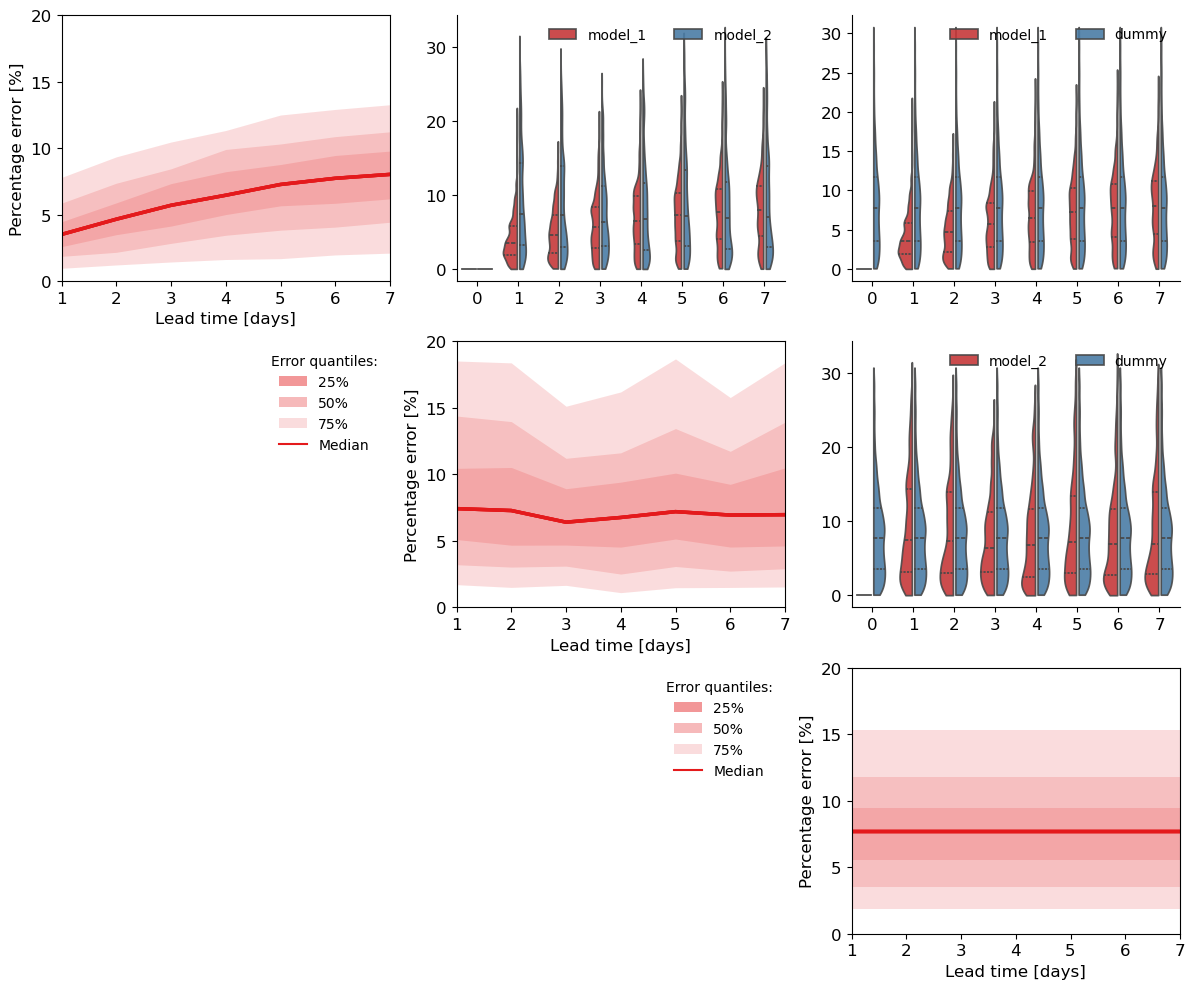

In [29]:
melted_results = generate_melted_error_df(matched_model_results)
plot_error_distribution_array(melted_results)

The previous image shows how the errors are spread at different horizons. In addition, the models are compared in the upper right subplots. It is easy to see that model 2 presents a significantly wider distribution of errors, even though the median is low enough. These results suggest that model 2 will miss the target more often than model 1.

This conclusion can be further validated looking at the violin plots where it can be seen that the distribution of errros from model 2 has always a longer tail than model 1. Interestingly, it can be noted that, even though model 2 distribution is wider than model 1, after lead time equal to 5 there is a shift and the median of errors is slightly lower in model 2 compared to model 1.

### Focused skill

All previous results have been computed using all available data. However, we might be interested in finetuning models to specific cases. For example, let´s assume it is critical that our model has a good performance when the value of _X_ is above a certain threshold. Then, we can filter the comparison with `modelskill` by doing:

In [21]:
threshold = 15000
skill_high_values = cmp.where(cmp.data.Observation > threshold).skill(by=["model", "lead_time"], metrics=metrics).sort_index()

where, the actual values used for the skill assessment are depicted in the image below.

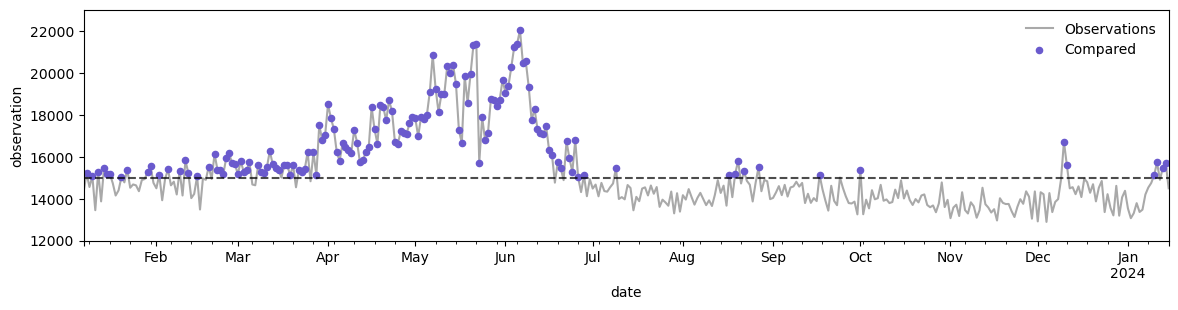

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
observations_.plot(ax=ax, label="Observations", color="darkgrey", zorder=0)
observations_[observations_ > threshold].to_frame().reset_index().plot(kind="scatter", x="date", y="observation", label="Compared", ax=ax, color="slateblue")
ax.axhline(y=threshold, alpha=0.7, color="black", linestyle="--")
ax.set_ylim(12000, 23000)
ax.legend(frameon=False)
plt.show()

Now, it is straightforward to repeat the previous analysis.

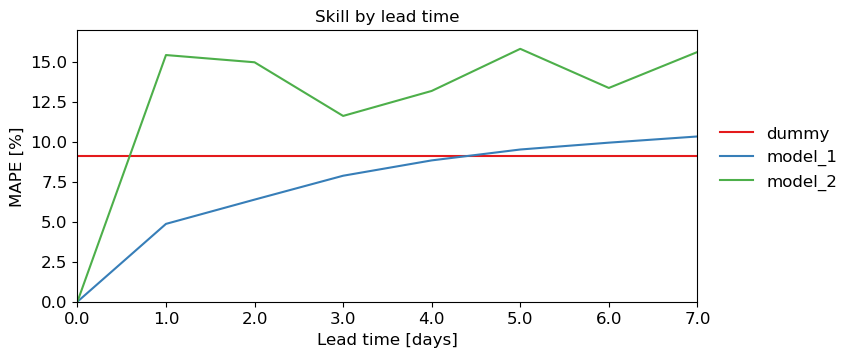

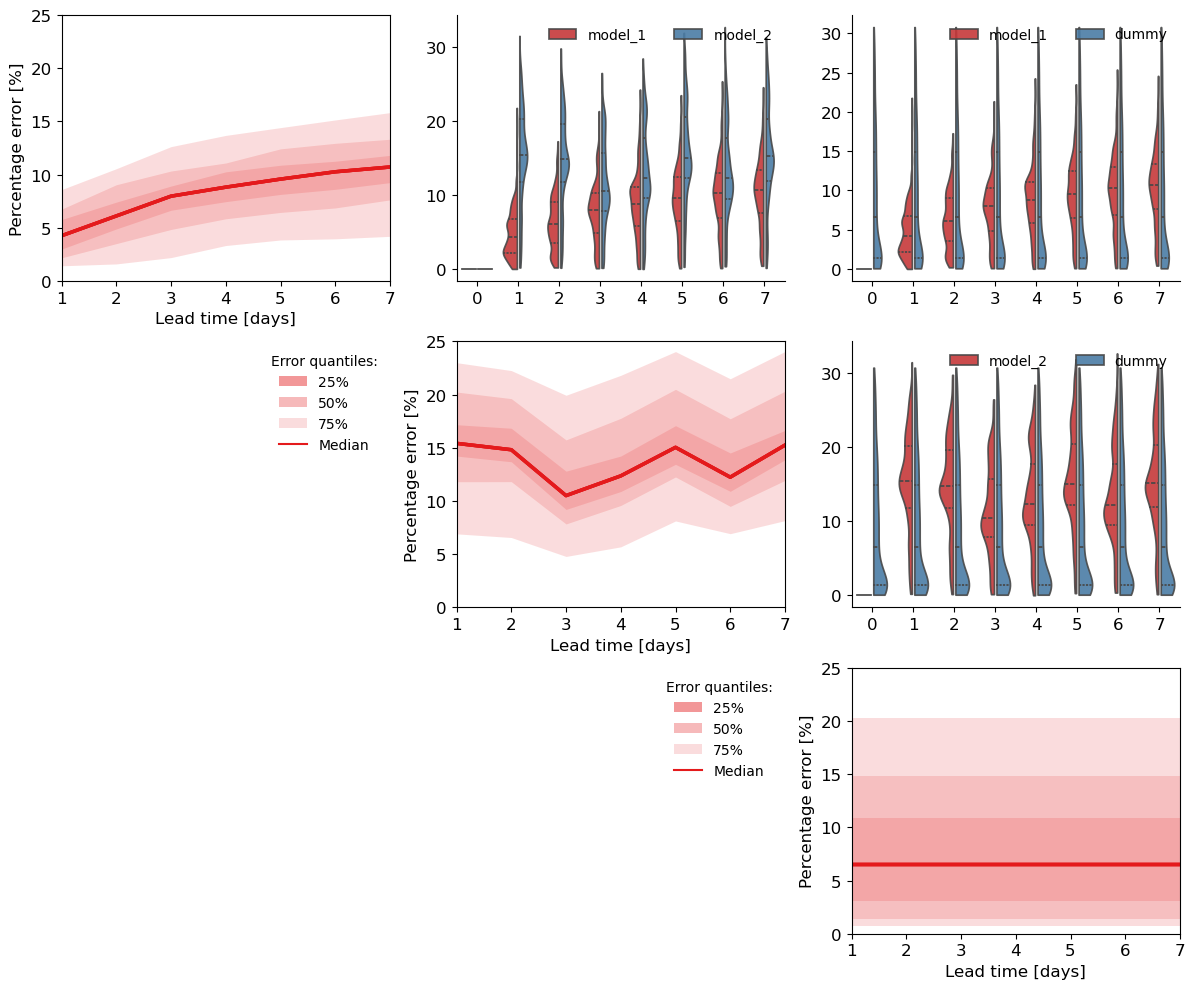

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
skill_high_values.mape.plot.line(ax=ax, figsize=(8, 4))
_format_ax(ax, xlims=(0, 7), ylims=(0, 17))
plt.show()

filtered_matched_results = matched_model_results.loc[matched_model_results["observation"] > threshold,:].copy()
melted_results = generate_melted_error_df(filtered_matched_results)
plot_error_distribution_array(melted_results, diag_ylims=(0, 25))

In this case, we observe that, compared to the dummy model, model 1 underperforms for longer lead times. Still, the tails of model 1 distribution is always the shortest. Depending on the application we might want to go back to improving model 1 to ensure a better performance for all horizons.